In [1]:
import os
import shutil
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.rc('font', size=12.0)

import tensorflow as tf
from keras import layers, mixed_precision, regularizers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

2024-10-28 20:21:01.461424: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 20:21:01.467148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 20:21:01.474523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 20:21:01.476622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 20:21:01.482515: I tensorflow/core/platform/cpu_feature_guar

In [2]:
model = ['nl']
label = ['NL']
x_names = ['a', 'alpha', 'param_S', 'param_L', '', 'trans1', '', 'trans2', '']
for k in range(len(model)):
    if model[k] == 'mp' or model[k] == 'np':
        x_names[4], x_names[6], x_names[8] = 'exp1', 'exp2', 'exp3'
    else:
        x_names[4], x_names[6], x_names[8] = 'csq1', 'csq2', 'csq3'
y_names = [f"R_{i}" for i in range(100)]

dir = '/home/anik/bamr/out/aff_inv/'
mchain = h5py.File(dir + 'nl_all', 'r')['markov_chain_0']
x_ncols, y_ncols = len(x_names), len(y_names)
nrows, data = mchain['nlines'][0], mchain['data']
X, Y = np.zeros((x_ncols, nrows)), np.zeros((y_ncols, nrows))
for i in range(x_ncols):
    X[i] = data[x_names[i]]
for i in range(y_ncols):
    Y[i] = data[y_names[i]]
X, Y = X.T, Y.T

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

x = scaler_X.fit_transform(X)

# Mask and scale only non-zero values in Y
nz = Y != 0
y = np.copy(Y)  # Copy Y to keep the structure with zeros intact
y[nz] = scaler_Y.fit_transform(Y[nz].reshape(-1, 1)).flatten()

x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.2, random_state=42)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_ts, y_ts, test_size=0.01, random_state=42)

In [3]:
tuner_dir = 'trials'

if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
# Define the DNN model with hyperparameter tuning
class DNNHyperModel(kt.HyperModel):
    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(layers.Input(shape=(x_ncols,)))
        model.add(layers.Dense(hp.Int('units_1', min_value=64, max_value=512, \
                                      step=64), activation='relu'))
        #model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.0, \
        #                                  max_value=0.6, step=0.05)))
        model.add(layers.Dense(hp.Int('units_2', min_value=64, max_value=512, \
                                      step=64), activation='relu'))
        #model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.0, \
        #                                  max_value=0.6, step=0.05)))
        model.add(layers.Dense(hp.Int('units_3', min_value=32, max_value=256, \
                                      step=64), activation='relu'))
        #model.add(layers.Dropout(hp.Float('dropout_3', min_value=0.0, \
        #                                  max_value=0.6, step=0.05)))

        # Tunable depth (number of hidden layers)
        #for i in range(hp.Int('num_layers', 1, 3)):  # 1 to 3 layers
        #    model.add(layers.Dense(hp.Int(f'units_{i}', min_value=32, \
        #                                  max_value=512, step=64), activation='relu'))
            #model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.0, \
            #                                  max_value=0.6, step=0.05)))

        model.add(layers.Dense(y_ncols, activation='linear'))
        
        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )
        return model

tuner = kt.RandomSearch(
    DNNHyperModel(),
    objective='val_mae',
    max_trials=50,
    executions_per_trial=1,
    directory='trials'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', \
                                              min_delta=1.0e-6, patience=10)

# Print the summary of search space
tuner.search_space_summary()

I0000 00:00:1730161320.557076  786897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730161320.577726  786897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730161320.577764  786897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730161320.580400  786897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730161320.580435  786897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 64, 'sampling': 'linear'}


In [5]:
# Run search with variable batch sizes
tuner.search(
    x_tr, y_tr,
    epochs=200,
    validation_data=(x_ts, y_ts),
    batch_size=32,
    callbacks=[stop_early]
)

Trial 50 Complete [00h 00m 39s]
val_mae: 0.0031064702197909355

Best val_mae So Far: 0.002782766940072179
Total elapsed time: 00h 32m 35s


In [8]:
tuner.results_summary(num_trials=1)

Results summary
Results in trials/untitled_project
Showing 1 best trials
Objective(name="val_mae", direction="min")

Trial 19 summary
Hyperparameters:
num_layers: 3
units_0: 480
units_1: 288
units_2: 480
Score: 0.002782766940072179


In [9]:
# Retrieve the best model and evaluate
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Optionally, retrain on the full dataset with optimal hyperparameters
training = best_model.fit(x_tr, y_tr, epochs=1000, validation_data=(x_ts, y_ts), \
                          batch_size=16, callbacks=[stop_early])

Epoch 1/1000
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0105 - mae: 0.0582 - val_loss: 7.4810e-04 - val_mae: 0.0147
Epoch 2/1000
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - loss: 6.6910e-04 - mae: 0.0133 - val_loss: 5.6454e-04 - val_mae: 0.0115
Epoch 3/1000
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - loss: 5.0654e-04 - mae: 0.0109 - val_loss: 4.3355e-04 - val_mae: 0.0100
Epoch 4/1000
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.9605e-04 - mae: 0.0095 - val_loss: 3.6122e-04 - val_mae: 0.0090
Epoch 5/1000
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.3513e-04 - mae: 0.0086 - val_loss: 3.3254e-04 - val_mae: 0.0087
Epoch 6/1000
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - loss: 3.0398e-04 - mae: 0.0081 - val_loss: 2.9047e-04 - val_mae: 0.0078
Epoch 7/1000
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - loss: 2.7054e-04 - mae: 0.0075 - val_loss: 2.5294e-04 - val_mae: 0.0071
Epoch 8/1000
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - loss: 2.3817e-04 - mae: 0.0069 - val_loss:

In [10]:
loss = best_model.predict(x_vl)
print("Loss MSE= ", loss[0])

# Save the best model
best_model.save("best_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Loss MSE=  [ 8.40621173e-01  6.70200109e-01  5.66622436e-01  4.89873290e-01
  4.33902651e-01  3.93031567e-01  3.55531782e-01  3.30283493e-01
  3.07109416e-01  2.92375177e-01  2.72950143e-01  2.63718694e-01
  2.54493356e-01  2.39799827e-01  2.36873671e-01  2.33765215e-01
  2.26739079e-01  2.20966786e-01  2.19774365e-01  2.18921036e-01
  2.19973147e-01  2.13683993e-01  2.13511422e-01  2.12873504e-01
  2.14760125e-01  2.17837468e-01  2.19425961e-01  2.16875374e-01
  2.15441033e-01  2.18418092e-01  2.20612898e-01  2.23916546e-01
  2.21714690e-01  2.28249505e-01  2.29357585e-01  2.31215015e-01
  2.28336573e-01  2.35885873e-01  2.33748898e-01  2.35326886e-01
  2.37474993e-01  2.38723367e-01  2.40397692e-01  2.40770325e-01
  2.40517095e-01  2.44906604e-01  2.46277094e-01  2.47947901e-01
  2.49077052e-01  2.48755127e-01  2.48746157e-01  2.55309194e-01
  2.52111524e-01  2.48634949e-01  2.52140611e-01  2.53644139e-01
  2.54987150e-01  2.54044533e-01  2.5038281

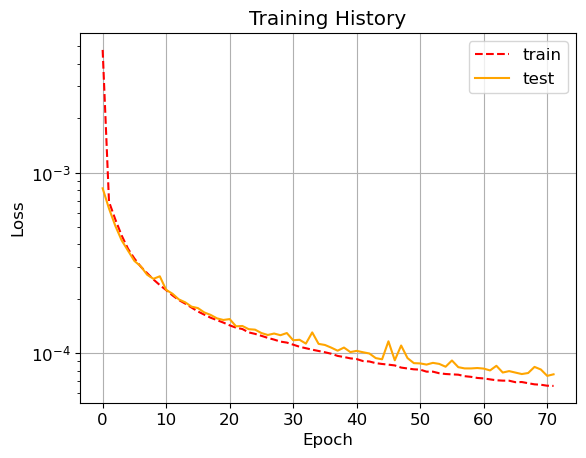

In [9]:
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


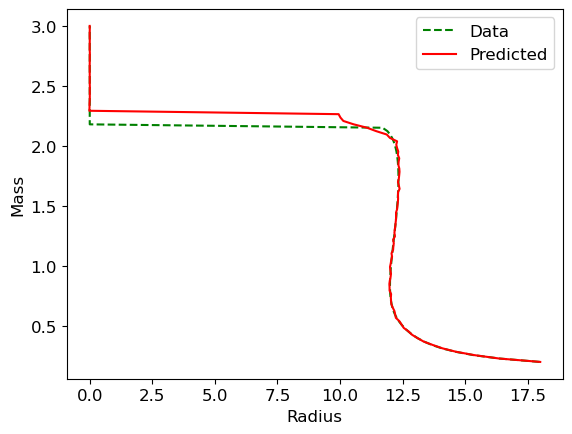

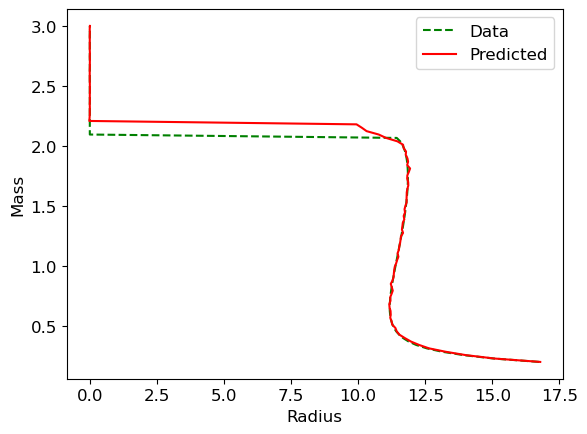

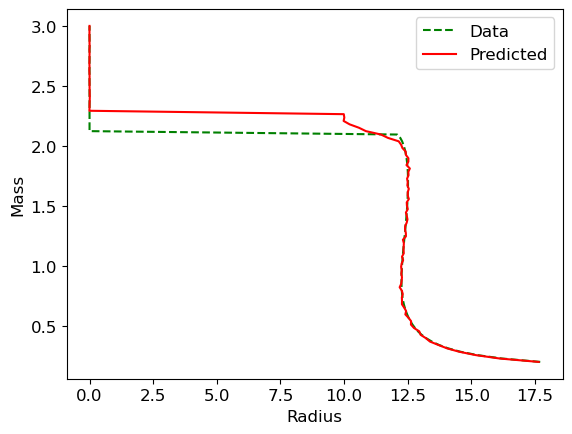

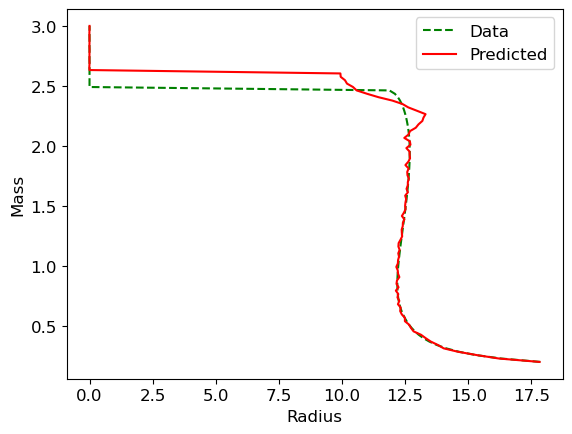

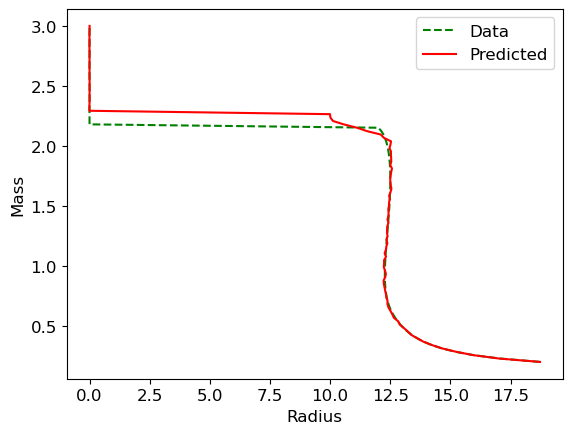

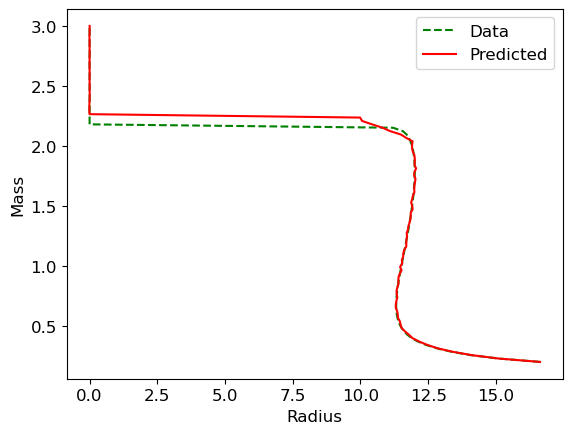

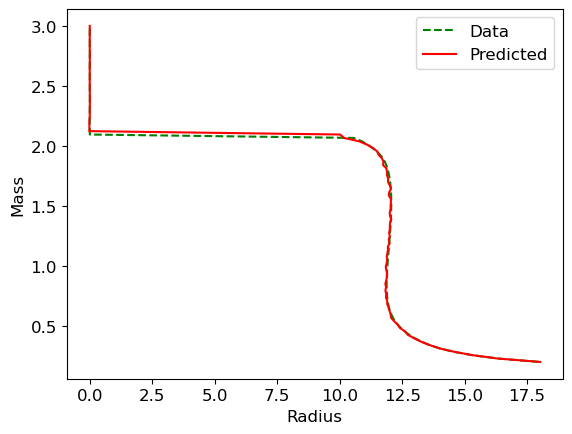

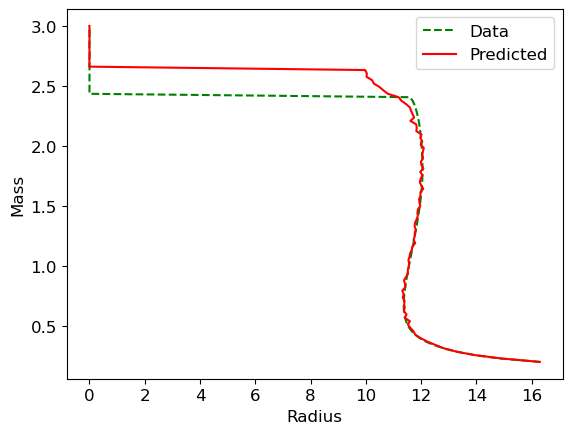

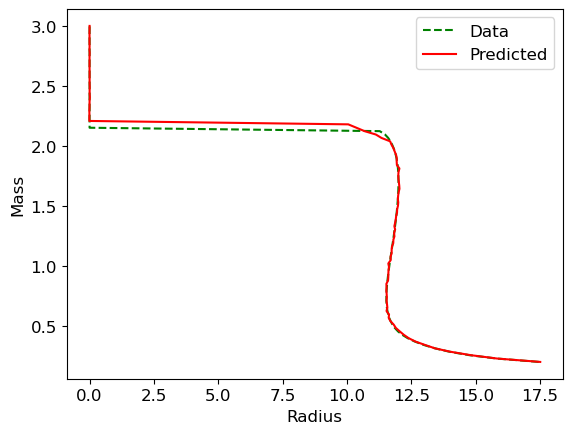

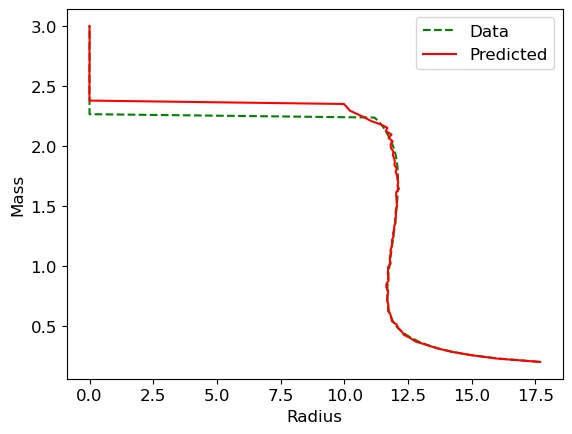

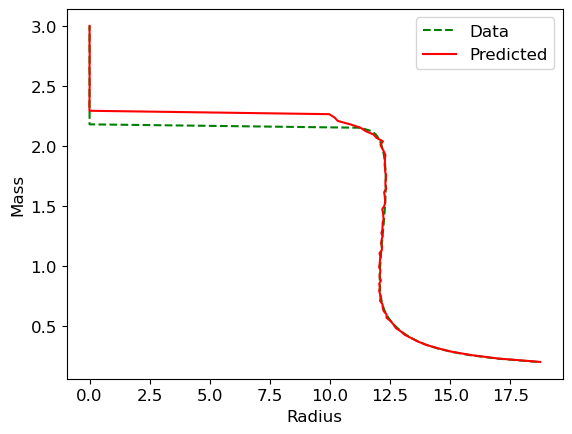

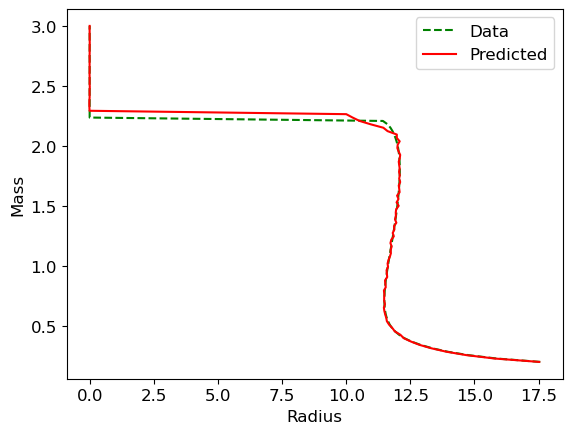

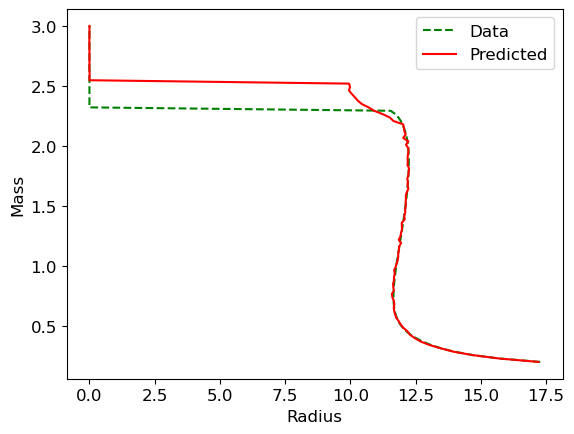

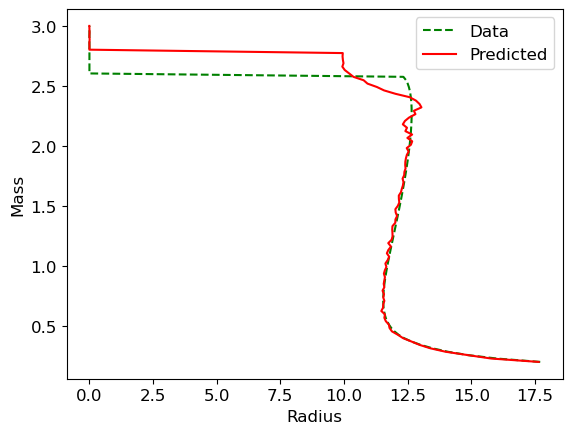

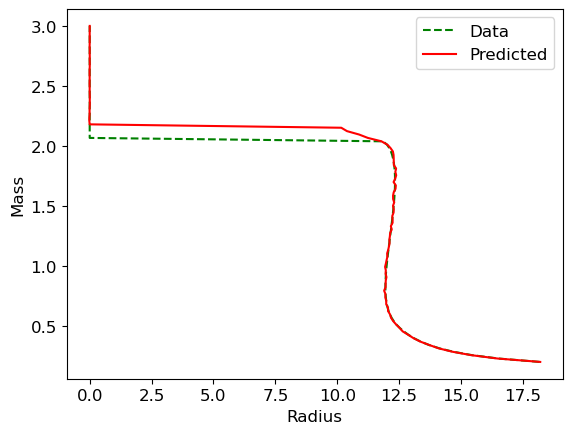

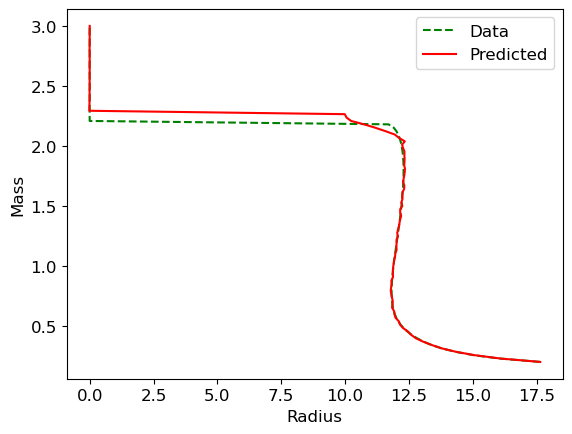

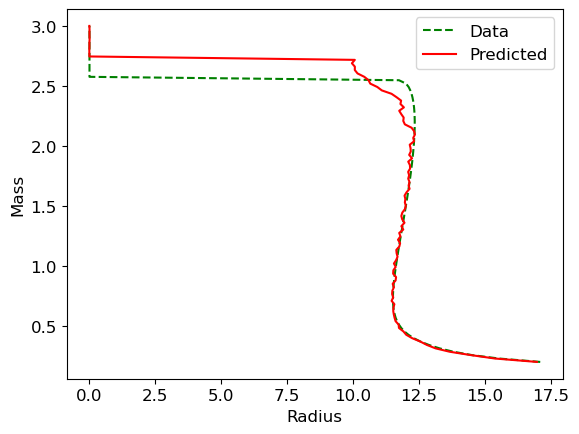

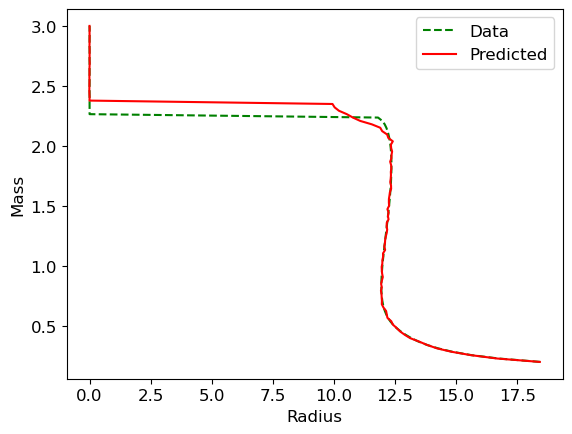

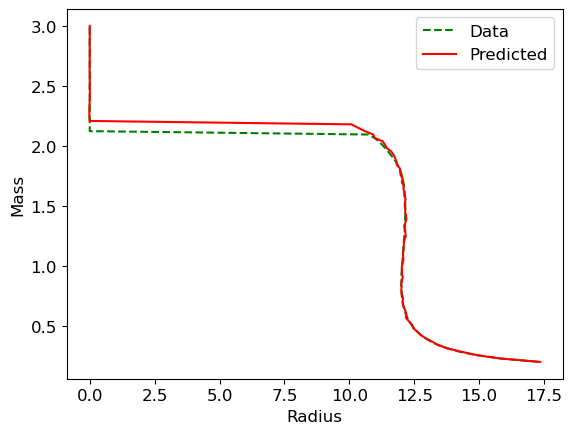

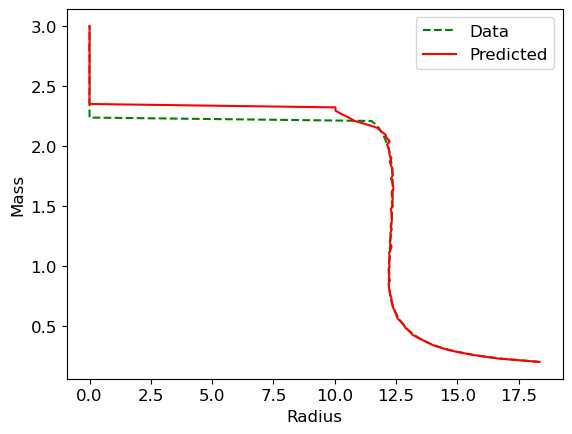

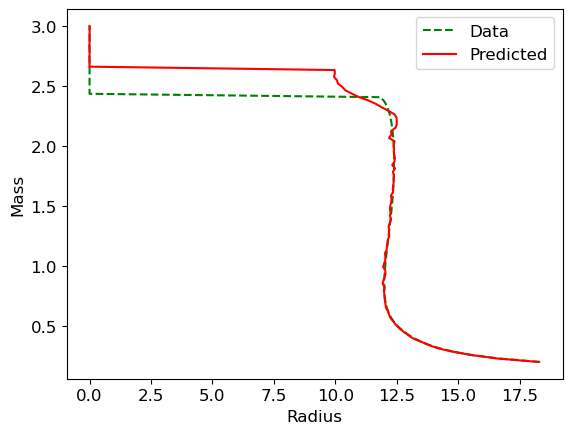

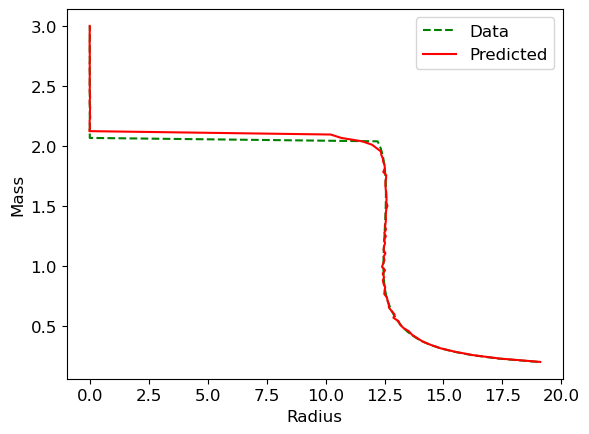

In [11]:
# Assume y_pr contains the normalized predictions and y_vl is the validation data
y_pr = best_model.predict(x_vl)

# Initialize arrays to store denormalized values
Y_pr = np.copy(y_pr)
Y_vl = np.copy(y_vl)

# Process each row individually
for i in range(y_pr.shape[0]):
    # Step 1: Identify the index of the first negative value in the row
    if np.any(y_pr[i] < 0):  # Check if there is any negative value
        i_nz = np.where(y_pr[i] < 0)[0][0]
        
        # Step 2: Set all values after the first negative value to zero
        y_pr[i, i_nz:] = 0

    # Step 3: Create a mask to identify non-zero values for denormalization
    nz_pr = y_pr[i] != 0
    nz_dt = y_vl[i] != 0

    # Step 4: Apply inverse_transform only on non-zero values
    if np.any(nz_pr):  # Check if there are any non-zero values
        Y_pr[i, nz_pr] = scaler_Y.inverse_transform(y_pr[i, nz_pr].reshape(-1, 1)).flatten()
    if np.any(nz_dt):  # Check if there are any non-zero values in the original validation data
        Y_vl[i, nz_dt] = scaler_Y.inverse_transform(y_vl[i, nz_dt].reshape(-1, 1)).flatten()

# Plot the results
m = np.linspace(0.2, 3.0, 100)
for i in range(22):
    plt.plot(Y_vl[i], m, label='Data', color='green', linestyle='--')
    plt.plot(Y_pr[i], m, label='Predicted', color='red')
    plt.xlabel("Radius")
    plt.ylabel("Mass")
    plt.legend()
    plt.show()


In [41]:
y_pr = best_model.predict(x_vl)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [44]:
y_vl[0]

array([0.8382187 , 0.67110568, 0.56291788, 0.48738756, 0.43195462,
       0.3895343 , 0.35692422, 0.33036958, 0.30872858, 0.29094868,
       0.27589215, 0.26302865, 0.25211339, 0.24312292, 0.23582064,
       0.22986825, 0.2256523 , 0.22218637, 0.21946365, 0.2177612 ,
       0.21629697, 0.21571833, 0.21524209, 0.21539376, 0.21559272,
       0.216292  , 0.21699129, 0.21805157, 0.21914513, 0.22041064,
       0.22177207, 0.22317937, 0.22470392, 0.22622847, 0.22781789,
       0.22941863, 0.23102064, 0.2326248 , 0.23422895, 0.23578161,
       0.23732605, 0.23883091, 0.24026051, 0.24169011, 0.24298053,
       0.24424449, 0.24542899, 0.24647841, 0.24752783, 0.24832494,
       0.24911039, 0.24970113, 0.25017064, 0.25050208, 0.25059848,
       0.25059202, 0.25024842, 0.24978935, 0.24892547, 0.24784753,
       0.24636654, 0.24442651, 0.24216288, 0.23903511, 0.23519756,
       0.23040372, 0.22421753, 0.21600004, 0.20459282, 0.18423092,
       0.        , 0.        , 0.        , 0.        , 0.     